<a href="https://colab.research.google.com/github/freshpex/stock-prediction/blob/main/AI_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List of datasets files
datasets = {
    'tesla': '/content/drive/MyDrive/ai_final/tesla.csv',
    'apple': '/content/drive/MyDrive/ai_final/apple.csv',
    'lgtelevision': '/content/drive/MyDrive/ai_final/lgtelevision.csv',
    'netflix': '/content/drive/MyDrive/ai_final/netflix.csv',
    'google': '/content/drive/MyDrive/ai_final/google.csv'
}

# Combine datasets into a single dataframe
file = '/content/drive/MyDrive/combined_dataset.csv'

df = pd.read_csv(file)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10409 non-null  object 
 1   Open       10409 non-null  float64
 2   High       10409 non-null  float64
 3   Low        10409 non-null  float64
 4   Close      10409 non-null  float64
 5   Adj Close  10409 non-null  float64
 6   Volume     10409 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 569.4+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10409.000000,10409.000000,10409.000000,10409.000000,10409.000000,1.040900e+04
mean,13.959910,14.111936,13.809163,13.966757,13.350337,3.321778e+08
std,30.169244,30.514878,29.835055,30.191696,29.911132,3.393344e+08
min,0.049665,0.049665,0.049107,0.049107,0.038384,0.000000e+00
25%,0.281964,0.287946,0.274554,0.281250,0.234799,1.247604e+08
50%,0.468750,0.477679,0.459821,0.468750,0.386853,2.199680e+08
75%,14.217857,14.364286,14.043571,14.206071,12.188149,4.126108e+08
max,182.630005,182.940002,179.119995,182.009995,181.778397,7.421641e+09


In [ ]:
# Remove time and timezone from 'Date' column
df['Date'] = df['Date'].str.split(' ').str[0]

# Convert the 'Date' column to datetime format, handling errors
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)

# drop rows with NaT values in the 'Date' column
df.dropna(subset=['Date'], inplace=True)

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

df.head()


<ipython-input-9-9e5010a83426>:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10409 entries, 1980-12-12 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10409 non-null  float64
 1   High       10409 non-null  float64
 2   Low        10409 non-null  float64
 3   Close      10409 non-null  float64
 4   Adj Close  10409 non-null  float64
 5   Volume     10409 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 569.2 KB


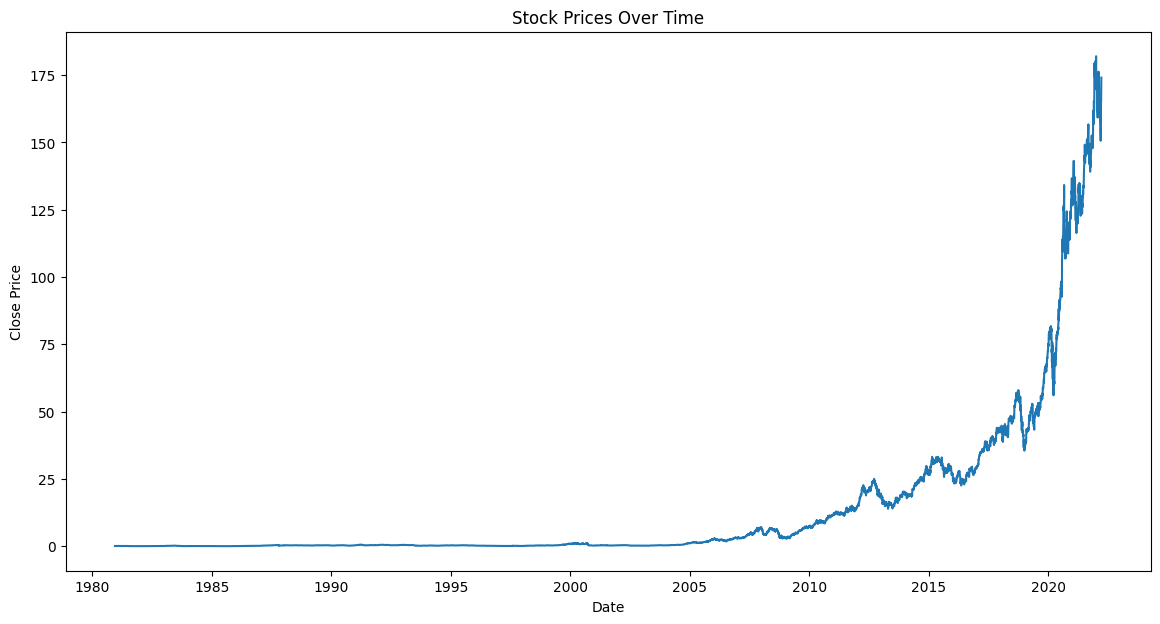

In [ ]:
# use pit to visualize stock prices over the time, so we can understand the trends
plt.figure(figsize=(14, 7))
plt.plot(df['Close'])
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

**LSTM**

In [ ]:
# we want to Normalize the data to make convergence faster
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

**Training** **and** **Testing**

In [ ]:
# split the scaled data into training sets, we are going to use 80 to 20%
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# we are using the inputs to predict the output based on the later days
def create_dataset(data, time_step=1):
    X = []
    y = []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshapes the input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


**Build and Train**

In [ ]:
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


**Train Model**

In [ ]:
# training the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=2)

Epoch 1/15
259/259 - 53s - loss: 4.2014e-05 - 53s/epoch - 204ms/step
Epoch 2/15
259/259 - 45s - loss: 1.2941e-05 - 45s/epoch - 175ms/step
Epoch 3/15
259/259 - 42s - loss: 1.0741e-05 - 42s/epoch - 161ms/step
Epoch 4/15
259/259 - 44s - loss: 1.2023e-05 - 44s/epoch - 170ms/step
Epoch 5/15
259/259 - 59s - loss: 1.2065e-05 - 59s/epoch - 226ms/step
Epoch 6/15
259/259 - 38s - loss: 9.5718e-06 - 38s/epoch - 148ms/step
Epoch 7/15
259/259 - 40s - loss: 1.3627e-05 - 40s/epoch - 153ms/step
Epoch 8/15
259/259 - 38s - loss: 1.3626e-05 - 38s/epoch - 147ms/step
Epoch 9/15
259/259 - 44s - loss: 9.7916e-06 - 44s/epoch - 171ms/step
Epoch 10/15
259/259 - 38s - loss: 8.5707e-06 - 38s/epoch - 145ms/step
Epoch 11/15
259/259 - 40s - loss: 1.1219e-05 - 40s/epoch - 154ms/step
Epoch 12/15
259/259 - 37s - loss: 7.9445e-06 - 37s/epoch - 144ms/step
Epoch 13/15
259/259 - 41s - loss: 7.7776e-06 - 41s/epoch - 158ms/step
Epoch 14/15
259/259 - 41s - loss: 1.0742e-05 - 41s/epoch - 157ms/step
Epoch 15/15
259/259 - 40s - l

**Plot the Loss**

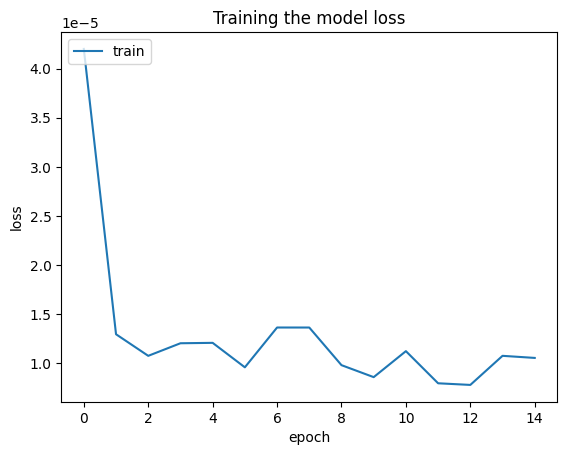

In [ ]:
plt.plot(hist.history['loss'])
plt.title('Training the model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train'], loc='upper left')
plt.show()

**Predictions**

In [ ]:
#train and test the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# since we scaled earlier we need to inverse and transform to get the actual stock prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


64/64 [==============================] - 3s 45ms/step


**Plot Predictions**

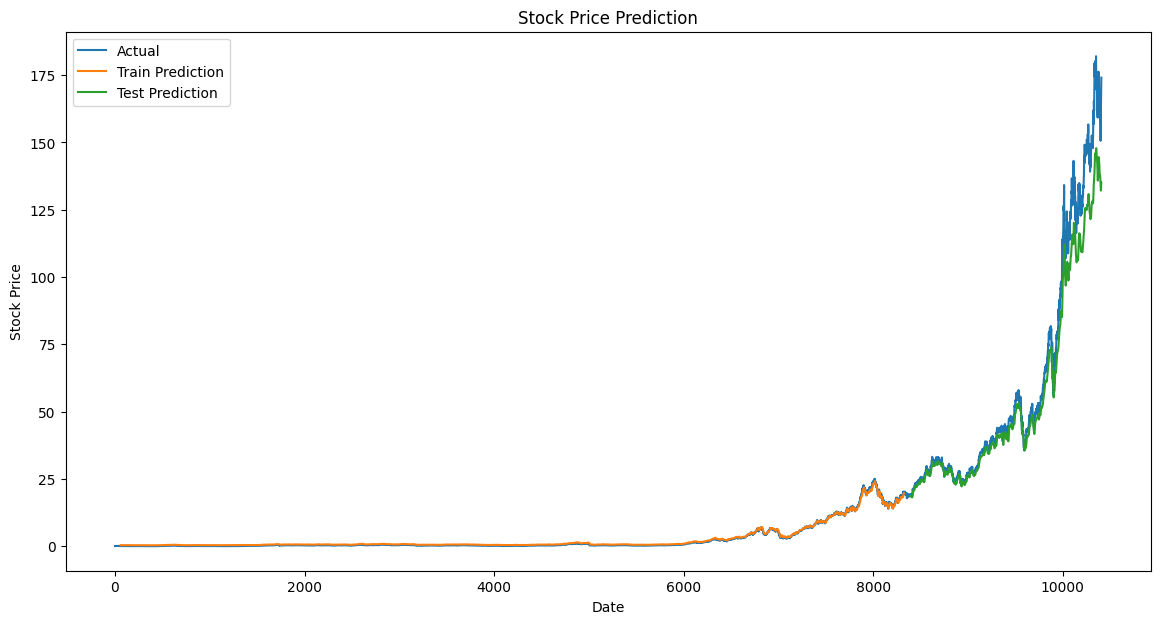

In [ ]:
# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['Actual', 'Train Prediction', 'Test Prediction'])
plt.show()


**Test Model With a Different Dataset**

In [ ]:
# load the data to test it
# file = '/content/drive/MyDrive/ai_final/lgtelevision.csv'
testData = pd.read_csv(file)

# ensuring that the Date column is parsed correctly
testData["Date"] = pd.to_datetime(testData["Date"])
testData.set_index('Date', inplace=True)

# this selects the 'Close' column and drop any None or empty values
testData = testData[['Close']].dropna()

# normalize the dataset using the same scaler we used during training
scaler = MinMaxScaler(feature_range=(0, 1))
input_closingScaled = scaler.fit_transform(testData.values)

# check the shape of the scaled data
input_closingScaled.shape

(10409, 1)

In [ ]:
# initialize variables for testing
x_test = []
time_step = 60
length = len(testData)

# create input sequences for the test model
for i in range(time_step, length):
    x_test.append(input_closingScaled[i-time_step:i, 0])

# convert to numpy array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape


(10349, 60, 1)

In [ ]:
# makes the prediction
y_pred = model.predict(x_test)

# we inverse transform the predictions to get actual stock prices
predicted_price = scaler.inverse_transform(y_pred)


324/324 [==============================] - 17s 51ms/step


**Visualization**

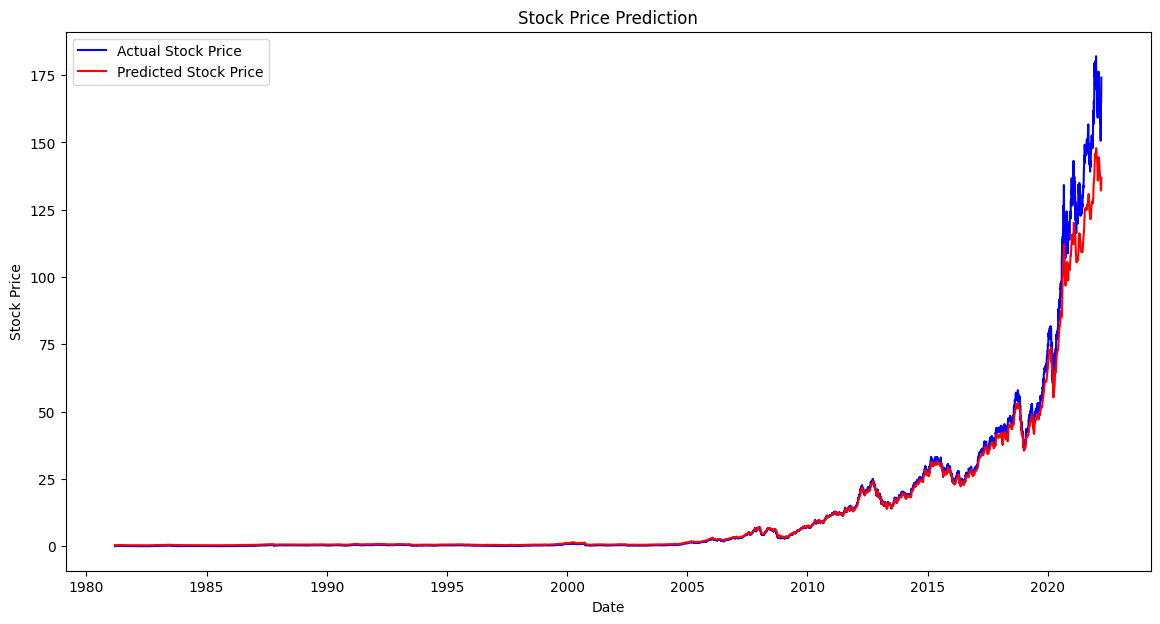

In [ ]:
# get the actual closing prices for comparison
y_test = testData.iloc[time_step:, 0].values

# plot the results
plt.figure(figsize=(14, 7))
plt.plot(testData.index[time_step:], y_test, color='blue', label='Actual Stock Price')
plt.plot(testData.index[time_step:], predicted_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**Performance Metrics**

In [ ]:
# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, predicted_price)
rmse = np.sqrt(mse)

# Print the performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 19.596947477127674
Root Mean Squared Error (RMSE): 4.426843963494497
Mean Squared Error (MSE): 19.596947477127674
Root Mean Squared Error (RMSE): 4.426843963494497


**Save model and scaler**

In [ ]:
import joblib

# Save the model
model.save('stock_prediction_model.h5')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')


# **Model Improvements**

---



Improve model using another dataset from a different source

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline


In [2]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

# For time stamps
from datetime import datetime


yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [3]:
# The new company dataset to improve model
company = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

In [4]:
# download the companies datasets
for data in company:
    globals()[data] = yf.download(data, start, end)


company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-06-14,183.369995,184.389999,182.020004,183.949997,183.226425,57462900,APPLE
2023-06-15,183.960007,186.520004,183.779999,186.009995,185.278336,65433200,APPLE
2023-06-16,186.729996,186.990005,184.270004,184.919998,184.192612,101235600,APPLE
2023-06-20,184.410004,186.100006,184.410004,185.009995,184.282257,49799100,APPLE
2023-06-21,184.899994,185.410004,182.589996,183.960007,183.236404,49515700,APPLE


#### Check stats for a selected company

In [5]:
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,183.140632,184.697510,181.746561,183.268427,182.976431,5.884911e+07
std,9.291031,9.357314,9.286137,9.387240,9.346894,2.188241e+07
min,165.350006,166.399994,164.080002,165.000000,165.000000,1.423541e+07
25%,175.309998,177.080002,173.740005,175.460007,175.039993,4.663810e+07
50%,183.550003,185.089996,182.020004,183.949997,183.395981,5.306800e+07
75%,190.500000,191.910004,189.399994,190.639999,190.157349,6.543450e+07
max,214.740005,220.199997,212.619995,214.240005,214.240005,1.981343e+08


In [6]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-06-14 to 2024-06-14
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          253 non-null    float64
 1   High          253 non-null    float64
 2   Low           253 non-null    float64
 3   Close         253 non-null    float64
 4   Adj Close     253 non-null    float64
 5   Volume        253 non-null    int64  
 6   company_name  253 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB


##### Check the stock prices over time

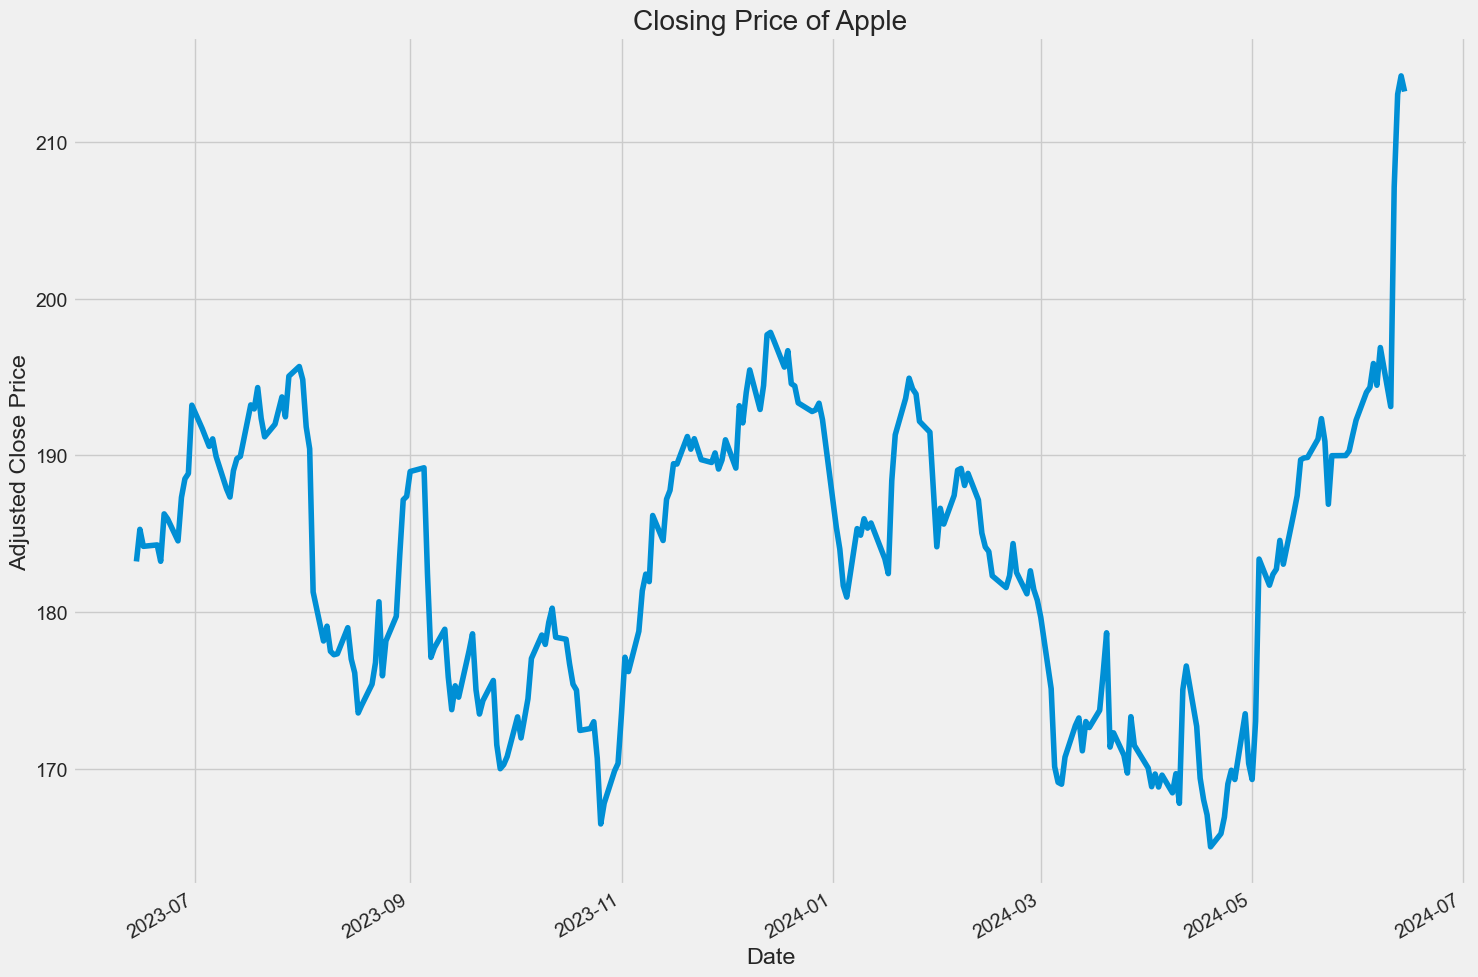

In [14]:
# Let's see a historical price of the closing price of Apple
plt.figure(figsize=(15, 10))
AAPL['Adj Close'].plot()
plt.ylabel('Adjusted Close Price')
plt.title("Closing Price of Apple")
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()
plt.show()



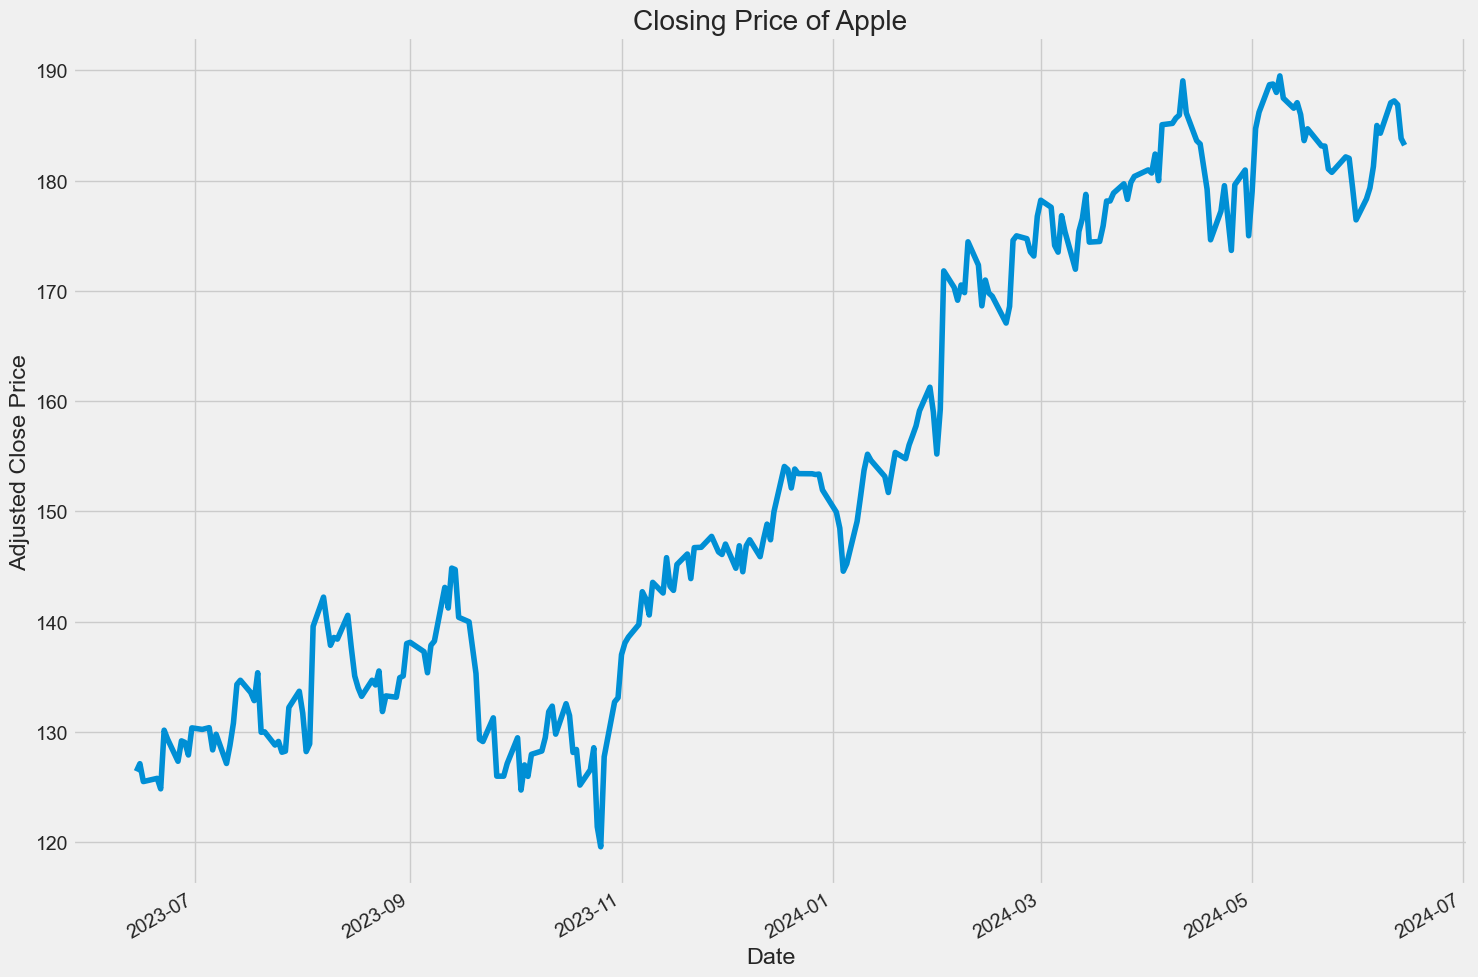

In [15]:
# Let's see a historical price of the closing price of Apple
plt.figure(figsize=(15, 10))
AMZN['Adj Close'].plot()
plt.ylabel('Adjusted Close Price')
plt.title("Closing Price of Apple")
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()
plt.show()


##### Training and Testing

In [16]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

962

In [17]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.20653349],
       [0.21287605],
       [0.20952004],
       ...,
       [0.21558551],
       [0.20616404],
       [0.20425541]])

In [18]:
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[array([0.20653349, 0.21287605, 0.20952004, 0.20979713, 0.20656431,
       0.21592419, 0.21493891, 0.21059768, 0.21918783, 0.22285174,
       0.22389856, 0.23738422, 0.23273508, 0.22925589, 0.23073375,
       0.22725457, 0.22088124, 0.21924942, 0.22445279, 0.22682352,
       0.22728539, 0.23744581, 0.23664526, 0.2408634 , 0.23479794,
       0.23113403, 0.23362794, 0.23630658, 0.23901604, 0.23507503,
       0.243111  , 0.24501991, 0.24243363, 0.23310453, 0.22876325,
       0.20049885, 0.19083106, 0.19375602, 0.18879897, 0.1881216 ,
       0.18756737, 0.1927092 , 0.18652056, 0.18381114, 0.17589831,
       0.177407  , 0.1815635 , 0.18584319, 0.19782016, 0.18322614,
       0.19009211, 0.19495679, 0.2070569 , 0.21792546, 0.21860283,
       0.22349833, 0.22423724, 0.20333144, 0.18685924, 0.18876815])]
[0.19240129099567466]

[array([0.20653349, 0.21287605, 0.20952004, 0.20979713, 0.20656431,
       0.21592419, 0.21493891, 0.21059768, 0.21918783, 0.22285174,
       0.22389856, 0.23738422, 0.23

##### Build and Train Model

In [19]:
# Build the LSTM model
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape= (x_train.shape[1], 1)))

model.add(LSTM(100, return_sequences=True))

model.add(LSTM(100, return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\epeki\scoop\apps\python\current\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Train the model
hist = model.fit(x_train, y_train, batch_size=32, epochs=15)


Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - loss: 0.0308
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - loss: 0.0098
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.0070
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0049
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0045
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0151
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.0040
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.0048
Epoch 9/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 0.0033
Epoch 10/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.0054
Epoch 11/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.0037
Epoch 12/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 0.0060
Epoch 13/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - loss: 0.0045
Epoch 14/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.0055
Epoch 15/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - lo

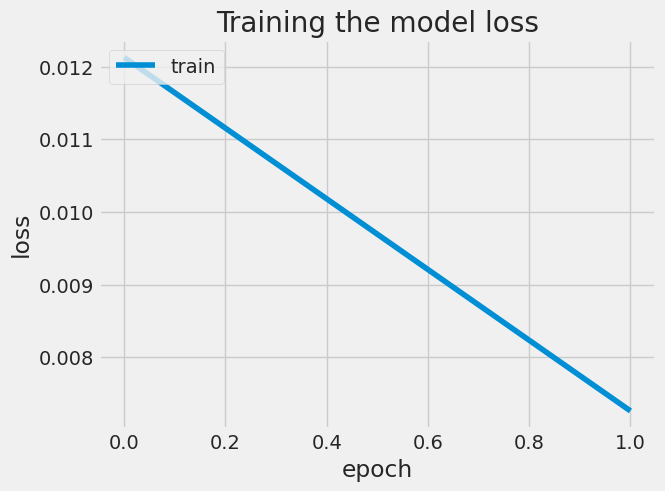

In [37]:
# plot the loss
plt.plot(hist.history['loss'])
plt.title('Training the model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train'], loc='upper left')
plt.show()

##### Prediction


In [22]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


3.4850757791455567

In [23]:
# Plot the prediction
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\epeki\AppData\Local\Temp\ipykernel_20904\1806255749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


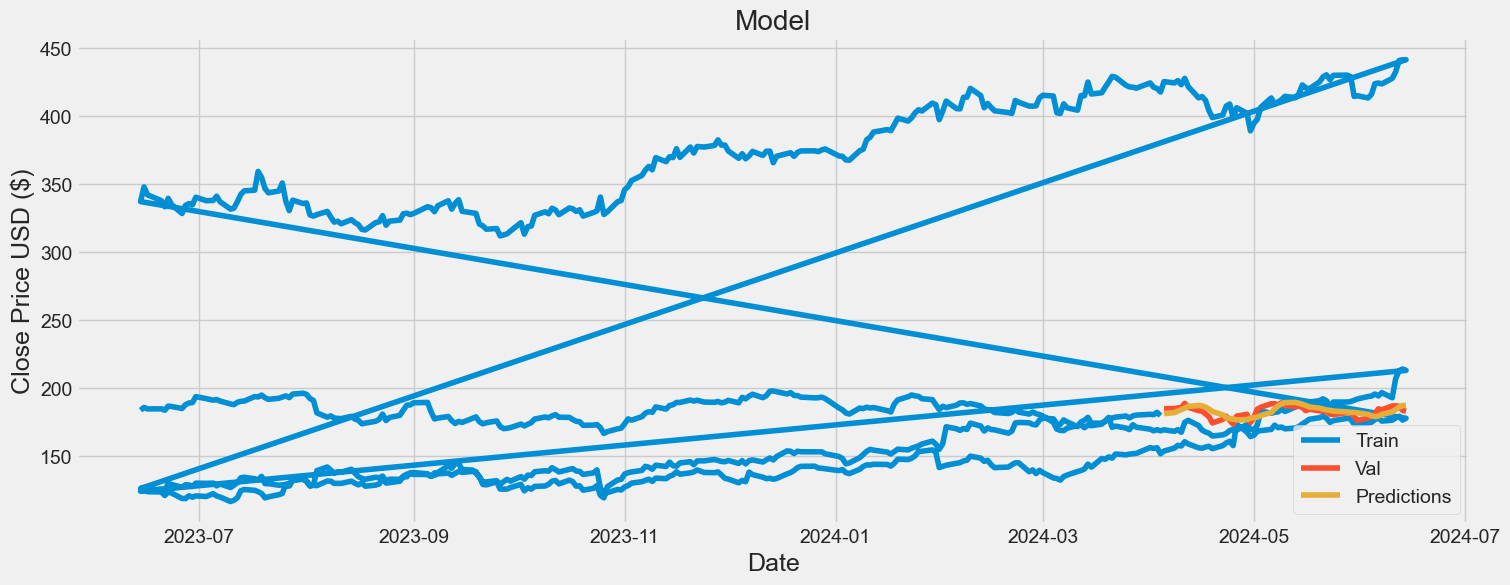

In [24]:
# Visualize the Prediction
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [25]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2024-04-05,185.070007,181.461044
2024-04-08,185.190002,182.175674
2024-04-09,185.669998,183.271408
2024-04-10,185.949997,184.451553
2024-04-11,189.050003,185.473740
2024-04-12,186.130005,186.737793
2024-04-15,183.619995,187.470673
2024-04-16,183.320007,187.190765
2024-04-17,181.279999,186.251617


#### Create and Save Improve Model

In [26]:
import joblib

# Save the new model
model.save('models/stock_prediction_model.h5')

# Save the scaler
joblib.dump(scaler, 'models/scaler.pkl')

['models/scaler.pkl']